In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import torch

import metatensor.torch as mts
from metatensor.torch import TensorMap, TensorBlock, Labels
from metatrain.gap.model import _FPS

from featomic.torch import systems_to_torch

from gpr import get_targets_from_xyz, PolynomialKernel, SoapCalculator, KernelCalculator, GPR

In [3]:
import yaml
with open('options.yaml', 'r') as file:
    options = yaml.safe_load(file)

In [4]:
torch.set_default_dtype(getattr(torch, options["torch"]["dtype"]))

In [5]:
# Read the train and test frames.
frames_train = ase.io.read(options["training_set"]["systems"], ":")
frames_val = ase.io.read(options["validation_set"]["systems"], ":")
train_id = list(range(len(frames_train)))
val_id = list(range(len(frames_train), len(frames_train) + len(frames_val)))

# Parse the energies from the xyz
train_targets = {
    "energy": get_targets_from_xyz(
        frames_train,
        train_id,
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
        use_gradients=options["training"]["use_gradients"],
        energy_key=options["training_set"]["targets"]["energy"]["key"],
        force_key=options["training_set"]["targets"]["forces"]["key"],
    )
}
val_targets = {
    "energy": get_targets_from_xyz(
        frames_val,
        val_id,
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
        use_gradients=options["training"]["use_gradients"],
        energy_key=options["validation_set"]["targets"]["energy"]["key"],
        force_key=options["validation_set"]["targets"]["forces"]["key"],
    )
}

# Initialize calculators
soap_calculator = SoapCalculator(options["model"]["soap"])
kernel_fn = PolynomialKernel(degree=options["model"]["krr"]["degree"])

In [6]:
# Convert the frames into auto-differentiable systems objects
systems_train = [
    sys.to(
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    )
    for sys in systems_to_torch(frames_train)
]
for sys in systems_train:
    sys.positions.requires_grad = True
    sys.cell.requires_grad = True

systems_val = [
    sys.to(
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    )
    for sys in systems_to_torch(frames_val)
]
for sys in systems_val:
    sys.positions.requires_grad = True
    sys.cell.requires_grad = True

# Now compute SOAP, select some sparse points, and compute the kernel
soap_vector_train = soap_calculator(
    systems_train,
    gradients=(
        ["positions"] if len(train_targets["energy"][0].gradients()) > 0 else None
    ),
)

if options["model"]["krr"]["num_sparse_points"] is None:
    num_sparse_points = len(soap_vector_train[0])
    print(f"using {num_sparse_points} sparse points")
else:
    num_sparse_points = options["model"]["krr"]["num_sparse_points"]
    assert num_sparse_points <= len(
        soap_vector_train[0]
    ), f"can only have a maximum of {len(soap_vector_train[0])} sparse points"
fps = _FPS(n_to_select=num_sparse_points)

# Select sparse points
soap_vector_train_fps = mts.remove_gradients(fps.fit_transform(soap_vector_train))

# Define the kernel calculator. This pre-computes k_mm.
kernel_calculator = KernelCalculator(
    kernel_fn=kernel_fn, sparse_points=soap_vector_train_fps
)
gpr = GPR(
    atomic_types=options["model"]["atomic_types"],
    kernel_calculator=kernel_calculator,
    dtype=getattr(torch, options["torch"]["dtype"]),
    device=options["torch"]["device"],
)

In [7]:
len(soap_vector_train_fps[0])

800

In [8]:
# import numpy as np

# with open("alpha_energy.txt", "w") as f:
#     for _ in systems_train:
#         f.write(f"{np.random.rand()}\n")

# with open("alpha_force.txt", "w") as f:
#     for frame in systems_train:
#         for atom in range(len(frame)):
#             for xyz in range(3):
#                 f.write(f"{np.random.rand()}\n")

In [9]:
len(frames_train)

192

In [10]:
import numpy as np
import torch
from metatensor.torch import Labels, TensorBlock

soap_train_vectors = []

for i in range(len(frames_train)):
    soap_vector = soap_calculator(
        systems_train[i],
        gradients=(
            ["positions"] if len(train_targets["energy"][0].gradients()) > 0 else None
        ),
    )
    soap_train_vectors.append(soap_vector)
print("Length: ", len(soap_train_vectors[0]))

Length:  1


In [11]:
# initialize merged blocks
merged_blocks = soap_train_vectors[0][0]

for i in range(1,len(frames_train)):
    block = soap_train_vectors[i][0]
    # set index 
    block.samples['system'][:] = i
    block.gradient('positions').samples['system'][:] = i
    # Detach and stack the values
    new_values = torch.cat([merged_blocks.values, block.values], dim=0)
    # Stack the samples manually
    new_samples_values = torch.cat([merged_blocks.samples.values, block.samples.values], dim=0)
    new_samples = Labels(
        names=merged_blocks.samples.names,
        values=new_samples_values
    )

    # Build the merged TensorBlock
    new_block = TensorBlock(
        values=new_values,
        samples=new_samples,
        components=merged_blocks.components,
        properties=merged_blocks.properties
    )

    # Merge gradients
    for parameter in merged_blocks.gradients_list():
        grad0 = merged_blocks.gradient(parameter)
        grad1 = block.gradient(parameter)

        # Step 1: fix the 'sample' column in grad1
        offset = merged_blocks.samples.values.shape[0]
        grad1_samples_fixed = grad1.samples.values.clone()
        sample_idx = grad1.samples.names.index("sample")
        grad1_samples_fixed[:, sample_idx] += offset  # Correct sample remapping!


        merged_grad_values = torch.cat([grad0.values, grad1.values], dim=0)
        merged_grad_samples_values = torch.cat([grad0.samples.values, grad1_samples_fixed], dim=0)
        merged_grad_samples = Labels(
            names=grad0.samples.names,
            values=merged_grad_samples_values
        )

        gradient_block = TensorBlock(
            values=merged_grad_values,
            samples=merged_grad_samples,
            components=grad0.components,
            properties=new_block.properties  # gradient must have same properties as main block
        )

        # Now add the gradient properly
        new_block.add_gradient(parameter, gradient_block)
    
    merged_blocks = new_block


#soap_vector_train = [merged_blocks]
len(new_block)


2103

In [12]:
from metatensor.torch import TensorMap, Labels

keys = Labels(
    names=["_"],
    values=torch.tensor([[0]])  # Adjust according to your descriptor keys
)

# SOAP train vectors
soap_vector_train_merged = TensorMap(
    keys=keys,
    blocks=[merged_blocks]
)

In [13]:
from metatensor.torch import allclose

# Returns True if they are numerically equivalent (like np.allclose)
allclose(soap_vector_train_merged, soap_vector_train)

True

In [14]:
def compare_tensor_maps_structure(tm1, tm2):
    issues = []

    # 1. Compare keys
    if tm1.keys.names != tm2.keys.names:
        issues.append(f"Key names mismatch: {tm1.keys.names} vs {tm2.keys.names}")
    if not torch.equal(tm1.keys.values, tm2.keys.values):
        issues.append("Key values differ")

    if len(tm1.keys) != len(tm2.keys):
        issues.append(f"Number of blocks differ: {len(tm1.keys)} vs {len(tm2.keys)}")

    # 2. Compare each block
    for i in range(len(tm1.keys)):
        b1 = tm1.block(i)
        b2 = tm2.block(i)

        if b1.samples.names != b2.samples.names:
            issues.append(f"Block {i}: sample names differ: {b1.samples.names} vs {b2.samples.names}")
        if b1.samples.values.shape != b2.samples.values.shape:
            issues.append(f"Block {i}: sample shapes differ: {b1.samples.values.shape} vs {b2.samples.values.shape}")

        if len(b1.components) != len(b2.components):
            issues.append(f"Block {i}: number of components differ")

        for j, (c1, c2) in enumerate(zip(b1.components, b2.components)):
            if c1.names != c2.names:
                issues.append(f"Block {i}, component {j}: component names differ")
            if c1.values.shape != c2.values.shape:
                issues.append(f"Block {i}, component {j}: component shapes differ")

        if b1.properties.names != b2.properties.names:
            issues.append(f"Block {i}: property names differ: {b1.properties.names} vs {b2.properties.names}")
        if b1.properties.values.shape != b2.properties.values.shape:
            issues.append(f"Block {i}: property shapes differ")

        if b1.values.shape != b2.values.shape:
            issues.append(f"Block {i}: values shape differ: {b1.values.shape} vs {b2.values.shape}")

        # Gradients
        grads1 = set(b1.gradients_list())
        grads2 = set(b2.gradients_list())
        if grads1 != grads2:
            issues.append(f"Block {i}: gradient parameters differ: {grads1} vs {grads2}")
        for g in grads1 & grads2:
            g1 = b1.gradient(g)
            g2 = b2.gradient(g)
            if g1.values.shape != g2.values.shape:
                issues.append(f"Block {i}, gradient '{g}': values shape differ: {g1.values.shape} vs {g2.values.shape}")
            if g1.samples.values.shape != g2.samples.values.shape:
                issues.append(f"Block {i}, gradient '{g}': sample shape differ")
            if g1.components != g2.components:
                issues.append(f"Block {i}, gradient '{g}': components differ")

    return issues

In [15]:
# diffs = compare_tensor_maps_structure(soap_vector_train, soap_vector_train_merged)
# if not diffs:
#     print("TensorMaps are structurally identical ✅")
# else:
#     print("Structural differences found:")
#     for diff in diffs:
#         print("-", diff)

In [16]:
soap_vector_train[0].gradient("positions")

Gradient TensorBlock ('positions')
    samples (33761): ['sample', 'system', 'atom']
    components (3): ['xyz']
    properties (448): ['neighbor_1_type', 'neighbor_2_type', 'l', 'n_1', 'n_2']
    gradients: None

In [17]:
ref_frames_train = ase.io.read("/home/apaulish/Documents/code/joe_davide/ext_data/train_n574_e26.xyz", ":")


frames_train[0].info['structure_id'], ref_frames_train[0].info['structure_id']

(413, 413)

In [18]:
ref_ids = [ref_frames_train[i].info['structure_id'] for i in range(len(ref_frames_train))]

for i in range(len(frames_train)):
    if frames_train[i].info['structure_id'] not in ref_ids:
        print(i)

In [19]:
def compute_force_error(atoms_1, atoms_2, force_errors, default_error=None):
    if atoms_1.get_number_of_atoms() != atoms_2.get_number_of_atoms():
        raise ValueError("Number of atoms in the two atoms objects are different.")
    if atoms_1.info['structure_id'] != atoms_2.info['structure_id']:
        raise ValueError("Structure IDs of the two atoms objects are different.")
    array_1 = atoms_1.arrays
    array_2 = atoms_2.arrays
    n_atoms, n_dim = array_1["dft_force"].shape

    errors_at = []
    for i in range(n_atoms):
        if default_error is not None:
            force_error = default_error
        else:
            force_error = np.linalg.norm(array_1["dft_force"][i] - array_2["dft_force"][i])
            if force_error < 0.0001:
                force_error = 0.0001
            #f_norm = np.linalg.norm(force_error)

        force_errors.append([force_error for i in range(n_dim)])

    #force_errors.append(errors_at)

    return force_errors

In [20]:
# force_errors = []
# for i in range(len(frames_train)):
#     force_errors = compute_force_error(frames_train[i], ref_frames_train[i], force_errors)


#force_errors = [[0.004, 0.004, 0.004] for i in range(len(force_errors))] # * np.array(force_errors)    

In [21]:
#np.min(force_errors), np.max(force_errors)

In [22]:
torch.Size([sum([len(sys) for sys in systems_train]), 3])

torch.Size([2103, 3])

In [23]:
# Regularizer - energy
if options["training"]["alpha_energy"]["read_from"] is None:  # homoscedastic energy
    alpha_energy = options["training"]["alpha_energy"]["value"]
else:
    energy_errors = np.loadtxt(options["training"]["alpha_energy"]["read_from"])
    #energy_errors = [0.15 for i in range(len(energy_errors))]
    alpha = 0.85 #0.085
    alpha_energy = alpha * torch.tensor(
        energy_errors,
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    )

# Regularizer - energy grads
if options["training"]["alpha_energy_grad"]["read_from"] is None:  # homoscedastic energy
    alpha_energy_grad = options["training"]["alpha_energy_grad"]["value"]
else:
    #0.15
    alpha_energy_grad = 1. * torch.tensor(
        np.loadtxt(options["training"]["alpha_energy_grad"]["read_from"]), #force_errors, 
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    ).reshape(-1, 3)

print("alpha_energy = ", alpha_energy)
print("alpha_energy_grad = ", alpha_energy_grad)

# Compute the kernel and aggregate over samples
k_nm = kernel_calculator(soap_vector_train_merged)
k_nm_reduced = mts.sum_over_samples(k_nm, ["atom", "center_type"])
#k_nm_reduced = k_nm

# Copy the targets for normalising
targets_baselined = {k: v.copy() for k, v in train_targets.items()}

# Fit the GPR model
gpr.fit(
    systems=systems_train,
    system_id=train_id,
    k_nm=k_nm_reduced,
    targets=targets_baselined,
    alpha_energy=alpha_energy,
    alpha_energy_grad=alpha_energy_grad,
)

alpha_energy =  0.001
alpha_energy_grad =  0.1


In [24]:
k_nm_reduced[0].shape

[192, 800]

In [25]:
# Convert the frames into auto-differentiable systems objects
systems_train = [
    sys.to(
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    )
    for sys in systems_to_torch(frames_train)
]
for sys in systems_train:
    sys.positions.requires_grad = True
    sys.cell.requires_grad = True

systems_val = [
    sys.to(
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    )
    for sys in systems_to_torch(frames_val)
]
for sys in systems_val:
    sys.positions.requires_grad = True
    sys.cell.requires_grad = True

# k_tt_train = kernel_fn(
#         soap_calculator(
#             systems_train,
#             gradients=None,
#     ), 
#         soap_calculator(
#             systems_train,
#             gradients=None,
#     )
# )
# k_tt_val = kernel_fn(
#         soap_calculator(
#             systems_val,
#             gradients=None,
#     ), 
#         soap_calculator(
#             systems_val,
#             gradients=None,
#     )
# )

# Make predictions
train_predictions = gpr(
    systems_train,
    train_id,
    k_tm=kernel_calculator(
        soap_calculator(
            systems_train,
            gradients=["positions"] if options["training"]["use_gradients"] else None,
        )
    ),
    predict_gradients=options["training"]["use_gradients"],
    predict_std_energy=options["training"]["predict_std_energy"],
    predict_std_energy_grad=options["training"]["predict_std_energy_grad"],
    #k_tt=k_tt_train
)
val_predictions = gpr(
    systems_val,
    val_id,
    k_tm=kernel_calculator(
        soap_calculator(
            systems_val,
            gradients=["positions"] if options["training"]["use_gradients"] else None,
        )
    ),
    predict_gradients=options["training"]["use_gradients"],
    predict_std_energy=options["training"]["predict_std_energy"],
    predict_std_energy_grad=options["training"]["predict_std_energy_grad"],
    #k_tt=k_tt_val
)
mts.equal_metadata_raise(train_targets["energy"], train_predictions["energy"])
mts.equal_metadata_raise(val_targets["energy"], val_predictions["energy"])

# Get the data arrays - energies (NOTE: plotting energy per atom here)
e_targ_train = train_targets["energy"][0].values.flatten().numpy() / np.array(
    [len(frame) for frame in frames_train]
)
e_pred_train = train_predictions["energy"][
    0
].values.flatten().detach().numpy() / np.array([len(frame) for frame in frames_train])
e_targ_val = val_targets["energy"][0].values.flatten().numpy() / np.array(
    [len(frame) for frame in frames_val]
)
e_pred_val = val_predictions["energy"][0].values.flatten().detach().numpy() / np.array(
    [len(frame) for frame in frames_val]
)

# Get the data arrays - forces. NOTE: we are predicting the negative of the forces here!
if options["training"]["use_gradients"]:
    minus_f_targ_train = (
        train_targets["energy"][0].gradient("positions").values.flatten().numpy()
    )
    minus_f_pred_train = (
        train_predictions["energy"][0]
        .gradient("positions")
        .values.flatten()
        .detach()
        .numpy()
    )
    minus_f_targ_val = (
        val_targets["energy"][0].gradient("positions").values.flatten().numpy()
    )
    minus_f_pred_val = (
        val_predictions["energy"][0]
        .gradient("positions")
        .values.flatten()
        .detach()
        .numpy()
    )

In [26]:
len(soap_vector_train_merged[0])

2103

In [27]:
n_train_structures = len(e_pred_train)
n_val_structures = len(e_pred_val)

n_train_structures, n_val_structures

(192, 200)

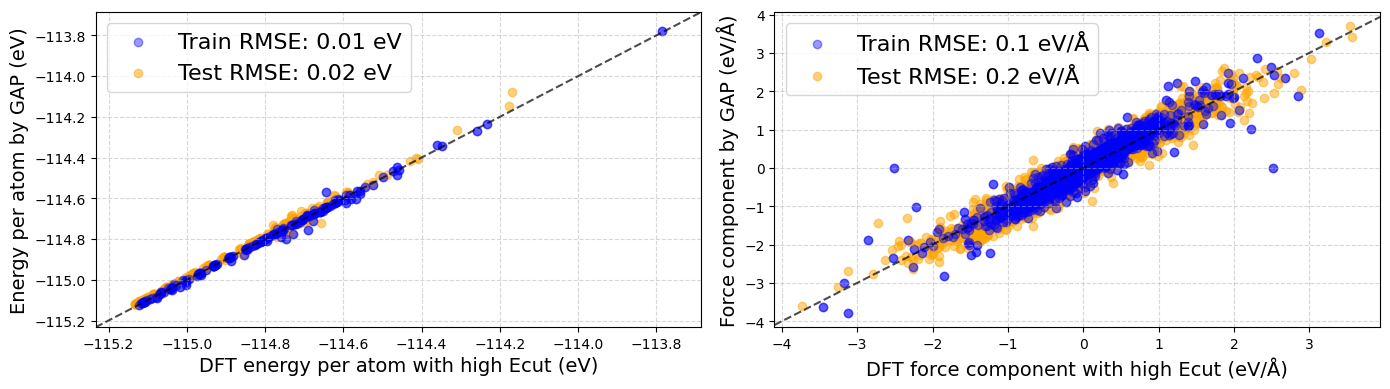

In [28]:
# Compute RMSE
rmse_energy_train = np.sqrt(np.mean((e_targ_train - e_pred_train) ** 2))
rmse_energy_val = np.sqrt(np.mean((e_targ_val - e_pred_val) ** 2))
rmse_force_train = np.sqrt(np.mean((minus_f_targ_train - minus_f_pred_train) ** 2))
rmse_force_val = np.sqrt(np.mean((minus_f_targ_val - minus_f_pred_val) ** 2))


# Parity plot. Plot the actual forces, so take the negative of the targets and predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Errors
if options["training"]["predict_std_energy"]:
    pred_std_train =  train_predictions["std_energy"][0].values.detach().numpy().reshape(n_train_structures,)
    pred_std_val =  val_predictions["std_energy"][0].values.detach().numpy().reshape(n_val_structures,)

    # Scaling
    scaling_factor = 1
    pred_std_train_scaled = pred_std_train / scaling_factor
    pred_std_val_scaled = pred_std_val / scaling_factor

    # Add error bars on energy values
    axes[0].errorbar(
        e_targ_train,
        e_pred_train,
        yerr=pred_std_train_scaled,
        fmt="none",
        ecolor="gray",
        alpha=0.4,
    )
    axes[0].errorbar(
        e_targ_val,
        e_pred_val,
        yerr=pred_std_val_scaled,
        fmt="none",
        ecolor="gray",
        alpha=0.4,
    )

axes[0].scatter(e_targ_train, e_pred_train, c="blue", alpha=0.4, label=f"Train RMSE: {rmse_energy_train:.1} eV")
axes[0].scatter(e_targ_val, e_pred_val, c="orange", alpha=0.5, label=f"Test RMSE: {rmse_energy_val:.1} eV")
axes[0].scatter(e_targ_train, e_pred_train, c="blue", alpha=0.4)

axes[0].grid(alpha=0.5, linestyle="--")
if options["training"]["use_gradients"]:
    axes[1].scatter(-minus_f_targ_train, -minus_f_pred_train, c="blue", alpha=0.4, label=f"Train RMSE: {rmse_force_train:.1} eV/Å")
    axes[1].scatter(-minus_f_targ_val, -minus_f_pred_val, c="orange", alpha=0.5, label=f"Test RMSE: {rmse_force_val:.1} eV/Å")
    axes[1].scatter(-minus_f_targ_train, -minus_f_pred_train, c="blue", alpha=0.4)
    axes[1].grid(alpha=0.5, linestyle="--")


# Add RMSE to the plot
# axes[0].text(
#     0.1,
#     0.9,
#     f"RMSE Energy Train: {rmse_energy_train:.4} eV\nRMSE Energy Val: {rmse_energy_val:.4} eV",
#     transform=axes[0].transAxes,
# )
# axes[1].text(
#     0.1,
#     0.9,
#     f"RMSE Force Train: {rmse_force_train:.4} eV\nRMSE Force Val: {rmse_force_val:.4} eV",
#     transform=axes[1].transAxes,
# )


# Format
[ax.axline([0, 0], [1, 1], linestyle="--", c="k", alpha=0.7) for ax in axes]
axes_lo = np.min(np.concatenate([e_targ_train, e_targ_val])) - 0.1
axes_hi = np.max(np.concatenate([e_targ_train, e_targ_val])) + 0.1
axes[0].set_xlim([axes_lo, axes_hi])
axes[0].set_ylim([axes_lo, axes_hi])

axes[0].set_xlabel("DFT energy per atom with high Ecut (eV)", fontsize=14) 
axes[1].set_xlabel("DFT force component with high Ecut (eV/Å)", fontsize=14) 
axes[0].set_ylabel("Energy per atom by GAP (eV)", fontsize=14)
axes[1].set_ylabel("Force component by GAP (eV/Å)", fontsize=14)
# axes[0].set_title("Energies", fontsize=16)
# axes[1].set_title("Forces", fontsize=16)
# legend top left
axes[0].legend(loc="upper left", fontsize=16)
axes[1].legend(loc="upper left", fontsize=16)

#make sure the labels are not cut off
plt.tight_layout()
#save high quality image
plt.savefig("images/n60_hom_high_fid.png", dpi=300)
#plt.savefig("images/sparse800_het_EF_n192_001_01.png", dpi=300)
#fig.savefig("images/n200_hom_mix_fid.png")

In [29]:
len(e_targ_train)

192

In [30]:
test_hom_en = 0.02
test_hom_force = 0.06

test_het_en = 0.005
test_het_force = 0.06

In [31]:
rmse_energy_val

0.02003014157100113

In [32]:
# Compute actual errors
actual_error = np.abs(e_targ_val - e_pred_val)

# Count how many times the predicted std is smaller than the actual error
underconfident_cases = np.sum(2.58 * pred_std_val_scaled < actual_error)
total_cases = len(actual_error)

# Compute fraction
underconfidence_fraction = underconfident_cases / total_cases

print(f"Fraction of Underconfident Predictions: {underconfidence_fraction:.3f}")

NameError: name 'pred_std_val_scaled' is not defined

In [361]:
# n60
fr_hom = 0.008
fr_het = 0.0
# n200
#sparse 50
fraction = 0.01
#sparse 800
fr_hom = 0.01

In [362]:
frac_hom_mix = 0.065 # if we compare 2 * std to error
# het energy + force
frac_het_mix_f_err = 0.073 # or 0.008 if we compare 2 * std to error
frac_het_mix = 0.065

frac_hom_0001_0002 = 0.23 # or 0.05 if we compare 2 * std to error

In [363]:
pred_std_val

array([0.01674921, 0.02903315, 0.01974634, 0.01782549, 0.02515781,
       0.02379645, 0.02181011, 0.02167218, 0.02579929, 0.02044987,
       0.02223286, 0.02173907, 0.01925939, 0.0211644 , 0.02201193,
       0.02822373, 0.02237582, 0.02915553, 0.02499904, 0.01916543,
       0.05643157, 0.05715045, 0.04352309, 0.03551654, 0.03605392,
       0.02593917, 0.02894805, 0.0200679 , 0.03011083, 0.04176749,
       0.02495996, 0.04031236, 0.04883596, 0.07324081, 0.04060425,
       0.05541048, 0.03056212, 0.0403185 , 0.04711708, 0.03241077,
       0.06472031, 0.05253204, 0.04027161, 0.04638416, 0.06922776,
       0.06198727, 0.06405782, 0.06455506, 0.08948652, 0.07794247,
       0.04902542, 0.08390802, 0.08253574, 0.083996  , 0.09585496,
       0.08977721, 0.08702392, 0.08394404, 0.08216768, 0.08091112,
       0.08720204, 0.08140441, 0.08554807, 0.08649584, 0.08352745,
       0.07685019, 0.07995466, 0.08162068, 0.09092036, 0.0867845 ,
       0.08000352, 0.08412926, 0.08833207, 0.0939959 , 0.09270

In [364]:
# compute correlation between predicted and actual error
import numpy as np
from scipy.stats import pearsonr



#remove nan values
pred_std = pred_std_val[~np.isnan(pred_std_val)]
e_targ_val = e_targ_val[~np.isnan(pred_std_val)]
e_pred_val = e_pred_val[~np.isnan(pred_std_val)]

#pred_std = pred_std_val
actual_error = np.abs(e_targ_val - e_pred_val)

# Assuming `pred_std` is the predicted standard deviation
# and `actual_error` is the actual absolute error
correlation, _ = pearsonr(2 * pred_std, np.abs(e_targ_val - e_pred_val))

#higher correlation (closer to 1) 
print(f"Pearson Correlation: {correlation:.3f}")
np.corrcoef(e_targ_val - e_pred_val, 2*pred_std_val)


Pearson Correlation: 0.283


array([[ 1.        , -0.32831309],
       [-0.32831309,  1.        ]])

In [365]:
hom_high_fid = 0.238
hom_mix_fid = 0.
het_mix_fid = 0.166

0.04


Text(0.5, 1.0, 'Predicted std vs Absolute error')

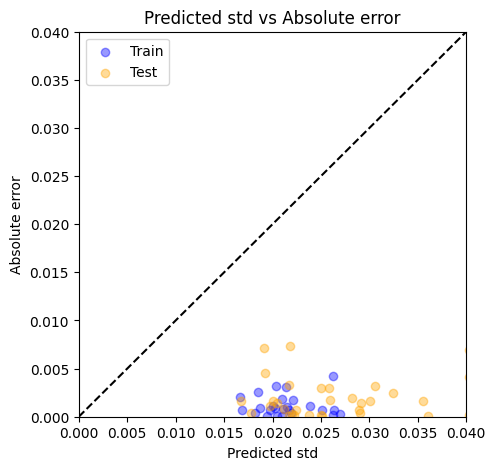

In [366]:
# plot pred_std vs actual rmse error
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(pred_std_train, np.abs(e_targ_train - e_pred_train), c="blue", alpha=0.4, label = "Train")

ax.scatter(pred_std_val, np.abs(e_targ_val - e_pred_val), c="orange", alpha=0.4, label = "Test")
ax.legend()
# add diagonal line
max_value = 0.04 #np.max(np.concatenate([ np.abs(e_targ_train - e_pred_train), np.abs(e_targ_val - e_pred_val)]))
print(max_value)
ax.axline([0, 0], [max_value, max_value], linestyle="--", c="k")
ax.set_xlim([0, max_value])
ax.set_ylim([0, max_value])
ax.set_xlabel("Predicted std")
ax.set_ylabel("Absolute error")
ax.set_title("Predicted std vs Absolute error")
#fig.savefig("images/pred_std_vs_abs_error_hom_mix.png")

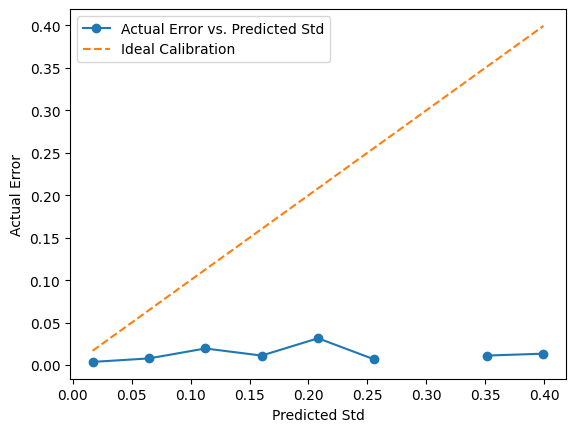

In [367]:
from scipy.stats import binned_statistic

bins = np.linspace(min(pred_std), max(pred_std), 10)  # 10 bins
bin_means, _, _ = binned_statistic(pred_std, actual_error, statistic="mean", bins=bins)

plt.plot(bins[:-1], bin_means, 'o-', label="Actual Error vs. Predicted Std")
plt.plot(bins[:-1], bins[:-1], '--', label="Ideal Calibration")  # y = x line
plt.xlabel("Predicted Std")
plt.ylabel("Actual Error")
plt.legend()
plt.show()

In [368]:
pred_std_train

array([0.01659882, 0.02044627, 0.02623687, 0.01814398, 0.02384424,
       0.02035629, 0.02143368, 0.01978782, 0.0200703 , 0.01845862,
       0.0210154 , 0.02146993, 0.0262969 , 0.02190444, 0.01946381,
       0.02022462, 0.02506473, 0.01875276, 0.0168548 , 0.02169872,
       0.02691807, 0.02213861, 0.02624542, 0.0210043 , 0.02104318])

In [369]:
pred_std_val

array([0.01674921, 0.02903315, 0.01974634, 0.01782549, 0.02515781,
       0.02379645, 0.02181011, 0.02167218, 0.02579929, 0.02044987,
       0.02223286, 0.02173907, 0.01925939, 0.0211644 , 0.02201193,
       0.02822373, 0.02237582, 0.02915553, 0.02499904, 0.01916543,
       0.05643157, 0.05715045, 0.04352309, 0.03551654, 0.03605392,
       0.02593917, 0.02894805, 0.0200679 , 0.03011083, 0.04176749,
       0.02495996, 0.04031236, 0.04883596, 0.07324081, 0.04060425,
       0.05541048, 0.03056212, 0.0403185 , 0.04711708, 0.03241077,
       0.06472031, 0.05253204, 0.04027161, 0.04638416, 0.06922776,
       0.06198727, 0.06405782, 0.06455506, 0.08948652, 0.07794247,
       0.04902542, 0.08390802, 0.08253574, 0.083996  , 0.09585496,
       0.08977721, 0.08702392, 0.08394404, 0.08216768, 0.08091112,
       0.08720204, 0.08140441, 0.08554807, 0.08649584, 0.08352745,
       0.07685019, 0.07995466, 0.08162068, 0.09092036, 0.0867845 ,
       0.08000352, 0.08412926, 0.08833207, 0.0939959 , 0.09270